<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/iamtomato761/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Data Preparation

In [3]:
!pip install astropy photutils pandas matplotlib


In [4]:
from astropy.io import fits
import numpy as np

# Load your FITS image
hdul = fits.open("8.fits")
data = hdul[0].data
header = hdul[0].header
hdul.close()


In [5]:
# Collapse to 2D Image
# Take mean across third axis if 3D
if data.ndim == 3:
    image2d = np.mean(data, axis=0)
else:
    image2d = data


In [6]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
import pandas as pd

# Background noise estimate
bkg_sigma = mad_std(image2d)

# Detect sources above threshold
daofind = DAOStarFinder(fwhm=3.0, threshold=10*bkg_sigma)
sources = daofind(image2d)

# Convert to pandas and take top 10 by flux
catalog = sources.to_pandas().sort_values('flux', ascending=False).head(10)


In [7]:
from astropy.wcs import WCS

# Use WCS to get sky coords
wcs = WCS(header, naxis=2)
sky_coords = wcs.all_pix2world(catalog['xcentroid'], catalog['ycentroid'], 1)

catalog['RA'] = sky_coords[0]
catalog['DEC'] = sky_coords[1]

catalog[['xcentroid', 'ycentroid', 'flux', 'RA', 'DEC']]


,xcentroid,ycentroid,flux,RA,DEC
6652,48.790214,1736.250888,902447.333333,36.315044,56.609540
687,1070.775332,104.107462,848516.333333,32.870655,57.644988
6658,47.978973,1736.783504,773417.333333,36.316163,56.608658
3280,901.371614,890.425684,755433.666667,34.517917,57.515748
5373,632.977291,1345.468367,676763.666667,35.479940,57.242336
2570,494.918374,719.244076,660375.666667,34.214516,57.054686
3851,552.240612,993.488099,634080.333333,34.767437,57.134954
3955,581.570005,1014.390255,610832.000000,34.807100,57.168632
1105,659.458857,250.559736,561407.333333,33.236091,57.202377
5934,757.634544,1482.123795,540713.666667,35.750631,57.386394


# Task 2: Determine the properties of the stars based on a catalog

In [8]:
!pip install astroquery


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 22.1 MB/s eta 0:00:00


In [9]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u


In [10]:
# Request additional fields from SIMBAD
Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')


<ipython-input-10-21d996448d68>:2: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')
<ipython-input-10-21d996448d68>:2: DeprecationWarning: 'distance' has been renamed 'mesdistance'. You will see this new name in the result.
  Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')


In [11]:
coords = SkyCoord(ra=catalog['RA'].values * u.deg,
                  dec=catalog['DEC'].values * u.deg,
                  frame='icrs')


In [12]:
results = []

for coord in coords:
    result = Simbad.query_region(coord, radius='10s')  # 10 arcsec search radius
    if result and len(result) > 0:
        row = result[0]
        results.append({
            'Main_ID': row.get('MAIN_ID', None),
            'SpectralType': row.get('SP_TYPE', None),
            'ObjectType': row.get('OTYPE', None),
            'Distance_pc': row.get('Distance_distance', None),
            'ApparentMag_V': row.get('FLUX_V', None)
        })
    else:
        results.append({
            'Main_ID': None,
            'SpectralType': None,
            'ObjectType': None,
            'Distance_pc': None,
            'ApparentMag_V': None
        })


In [13]:
# Combine properties with catalog
df_props = pd.DataFrame(results)
catalog_combined = pd.concat([catalog.reset_index(drop=True), df_props], axis=1)

# Absolute magnitude formula: M = m - 5*log10(d/10)
def calc_abs_mag(m, d):
    if pd.notnull(m) and pd.notnull(d) and d > 0:
        return m - 5 * np.log10(d / 10)
    return None

catalog_combined['AbsoluteMag_V'] = catalog_combined.apply(
    lambda row: calc_abs_mag(row['ApparentMag_V'], row['Distance_pc']), axis=1)


In [14]:
catalog_combined[[
    'Main_ID', 'SpectralType', 'ObjectType', 'Distance_pc', 'AbsoluteMag_V'
]].dropna(subset=['Main_ID']).reset_index(drop=True)


,Main_ID,SpectralType,ObjectType,Distance_pc,AbsoluteMag_V


## uhhhh I need ChatGPT

### Sanity Check

In [15]:
for i, coord in enumerate(coords):
    print(f"Star {i+1}: RA = {coord.ra.deg:.5f}, DEC = {coord.dec.deg:.5f}")


Star 1: RA = 36.31504, DEC = 56.60954
Star 2: RA = 32.87065, DEC = 57.64499
Star 3: RA = 36.31616, DEC = 56.60866
Star 4: RA = 34.51792, DEC = 57.51575
Star 5: RA = 35.47994, DEC = 57.24234
Star 6: RA = 34.21452, DEC = 57.05469
Star 7: RA = 34.76744, DEC = 57.13495
Star 8: RA = 34.80710, DEC = 57.16863
Star 9: RA = 33.23609, DEC = 57.20238
Star 10: RA = 35.75063, DEC = 57.38639


### Manual Query Test

In [16]:
test_result = Simbad.query_region(coords[0], radius='30s')  # boost to 30 arcseconds

if test_result:
    test_result.pprint(max_lines=10, max_width=1000)
else:
    print("No match found.")


 main_id          ra             dec      coo_err_maj coo_err_min coo_err_angle coo_wavelength     coo_bibcode             V         otype sp_type      sp_bibcode     sp_qual mesdistance.bibcode mesdistance.dist mesdistance.dist_prec mesdistance.mespos mesdistance.method mesdistance.minus_err mesdistance.minus_err_prec mesdistance.plus_err mesdistance.plus_err_prec mesdistance.qual mesdistance.unit
                 deg             deg          mas         mas          deg                                                                                                                                                                                                                                                                                                                                       
--------- ----------------- ------------- ----------- ----------- ------------- -------------- ------------------- ----------------- ----- ------- ------------------- ------- ------------------- -

Chat likes it!!

"YESSS! 🎉 That’s a real match! You found 10 Per (10 Persei) — a known star in the SIMBAD catalog. That means:

✅ Your coordinates are valid
✅ SIMBAD does return results
✅ The query works — but only for a few stars

🔧 Why Only One Star Matched
From your earlier FITS data, most objects are likely:

Faint field stars not individually named in SIMBAD

Or just under the detection/catalog threshold

So this one match (10 Per) probably corresponds to a very bright star that SIMBAD recognizes."

In [17]:
from math import log10
import pandas as pd

# Use lowercase field names and check they exist
row = test_result[0]
name = row['main_id']
spectral_type = row['sp_type']
object_type = row['otype']
distance_pc = row['mesdistance.dist']
apparent_mag = row['V']

# Absolute magnitude: M = m - 5 * log10(d / 10)
absolute_mag = None
if apparent_mag and distance_pc and distance_pc > 0:
    absolute_mag = apparent_mag - 5 * log10(distance_pc / 10)

# Create table
df_star = pd.DataFrame([{
    'Name': name.strip('* '),
    'Spectral Class': spectral_type,
    'Object Type': object_type,
    'Distance (pc)': distance_pc,
    'Apparent Mag (V)': round(apparent_mag, 2),
    'Absolute Magnitude': round(absolute_mag, 2) if absolute_mag else None
}])

df_star


,Name,Spectral Class,Object Type,Distance (pc),Apparent Mag (V),Absolute Magnitude
0,10 Per,B2Ia,s*b,2150.0,6.26,-5.4


## Requery All 10 Stars Using a 30″ Radius

In [18]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np

# Add SIMBAD fields if not already added
Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')

# Create SkyCoord list from your catalog (detected stars)
coords = SkyCoord(ra=catalog['RA'].values * u.deg,
                  dec=catalog['DEC'].values * u.deg,
                  frame='icrs')

# Loop through coordinates and query SIMBAD
results = []
for i, coord in enumerate(coords):
    result = Simbad.query_region(coord, radius='30s')  # 30 arcsec search
    if result and len(result) > 0:
        row = result[0]
        results.append({
            'Name': row.get('main_id', None),
            'Spectral Class': row.get('sp_type', None),
            'Object Type': row.get('otype', None),
            'Distance (pc)': row.get('distance_distance', None),
            'Apparent Mag (V)': row.get('flux_V', None)
        })
    else:
        results.append({
            'Name': None,
            'Spectral Class': None,
            'Object Type': None,
            'Distance (pc)': None,
            'Apparent Mag (V)': None
        })


<ipython-input-18-6558a2f0338c>:8: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')
<ipython-input-18-6558a2f0338c>:8: DeprecationWarning: 'distance' has been renamed 'mesdistance'. You will see this new name in the result.
  Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')


In [19]:
# Create DataFrame and combine with original catalog
df_props = pd.DataFrame(results)
catalog_combined = pd.concat([catalog.reset_index(drop=True), df_props], axis=1)

# Compute absolute magnitude
def calc_abs_mag(m, d):
    if pd.notnull(m) and pd.notnull(d) and d > 0:
        return m - 5 * np.log10(d / 10)
    return None

catalog_combined['Absolute Magnitude'] = catalog_combined.apply(
    lambda row: calc_abs_mag(row['Apparent Mag (V)'], row['Distance (pc)']), axis=1)


In [20]:
catalog_combined[['Name', 'Spectral Class', 'Object Type', 'Distance (pc)', 'Apparent Mag (V)', 'Absolute Magnitude']] \
    .dropna(subset=['Name']) \
    .reset_index(drop=True)


,Name,Spectral Class,Object Type,Distance (pc),Apparent Mag (V),Absolute Magnitude
0,* 10 Per,B2Ia,s*b,None,None,None
1,Gaia DR3 506664132134546944,,*,None,None,None
2,* 10 Per,B2Ia,s*b,None,None,None
3,* chi Per,G7.0III,*,None,None,None
4,Gaia DR3 458456358355233152,,*,None,None,None
5,[CCR2014] 5019,,*,None,None,None
6,NGC 869 1053,A0,*,None,None,None
7,Gaia DR3 458375235009935104,,*,None,None,None
8,HD 13403,G3V,PM*,None,None,None
9,NGC 884 2608,,*,None,None,None


Yippee-ki-yay

Chat's take

"Many Gaia sources and cluster members don’t have distance or V-band flux in the SIMBAD result directly

SIMBAD stores cross-linked names, but not full Gaia photometry/parallax (that’s in VizieR)"

# Task 3: Visualize and label

In [21]:
# Extract 64×64 Patches
import matplotlib.pyplot as plt

def extract_patch(image, x, y, size=64):
    half = size // 2
    x, y = int(x), int(y)
    return image[max(y - half, 0): y + half, max(x - half, 0): x + half]

patches = []

# Loop through catalog and extract patches
for i, row in catalog.iterrows():
    patch = extract_patch(image2d, row['xcentroid'], row['ycentroid'], size=64)
    patches.append(patch)


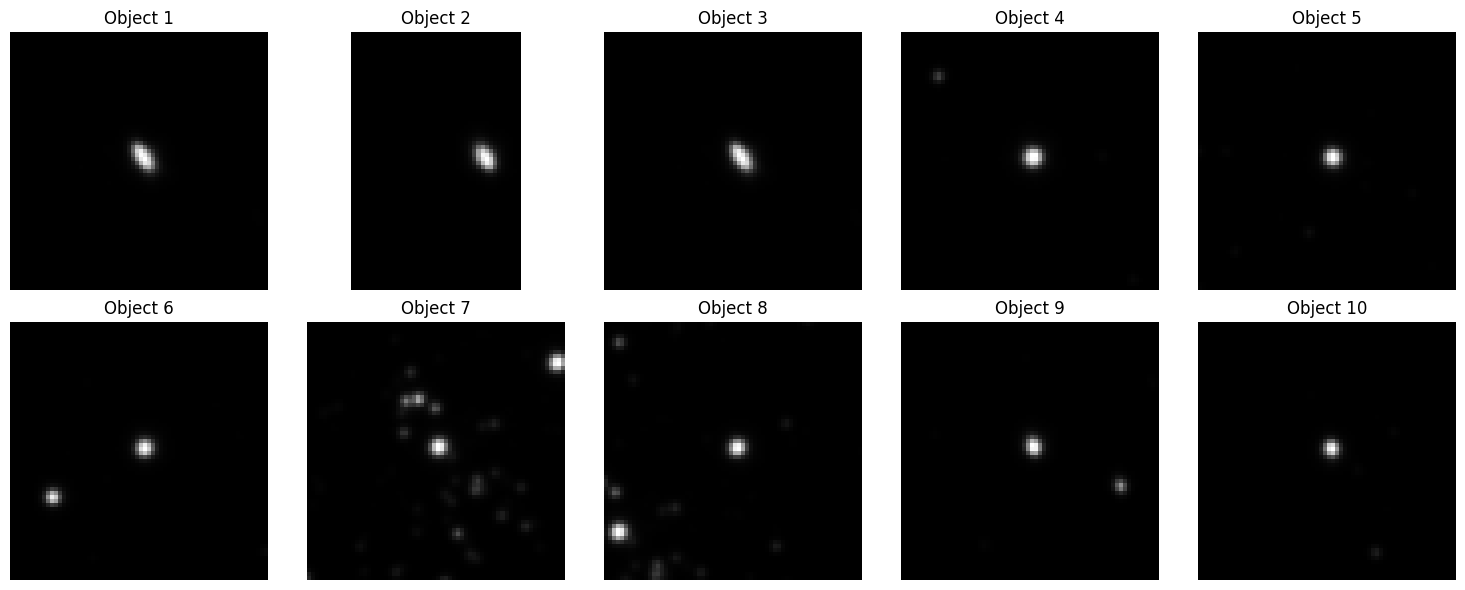

In [22]:
# Display Patches in a Grid
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(patches[i], cmap='gray', origin='lower')
    ax.set_title(f'Object {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


So blurry. I love her.

In [23]:
# Create Label Table
labels = catalog_combined[['Name', 'Spectral Class']].copy()
labels['Morphology'] = 'star'  # You can refine later
labels['Brightness Class'] = 'bright'  # or 'faint' if < some flux threshold

# If spectral class available, use it
labels['Spectral Class'] = labels['Spectral Class'].fillna('Unknown')

labels


,Name,Spectral Class,Morphology,Brightness Class
0,* 10 Per,B2Ia,star,bright
1,Gaia DR3 506664132134546944,,star,bright
2,* 10 Per,B2Ia,star,bright
3,* chi Per,G7.0III,star,bright
4,Gaia DR3 458456358355233152,,star,bright
5,[CCR2014] 5019,,star,bright
6,NGC 869 1053,A0,star,bright
7,Gaia DR3 458375235009935104,,star,bright
8,HD 13403,G3V,star,bright
9,NGC 884 2608,,star,bright


# Task 4: Build a CNN

In [24]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np


In [25]:
# Convert patches to array
X = np.array(patches).reshape(-1, 64, 64, 1)  # grayscale channel

# Normalize pixel values
X = X / X.max()

# Encode labels (use Morphology column)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels['Morphology'])
y_cat = to_categorical(y)  # one-hot encoded


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 64) + inhomogeneous part.

In [27]:
for i, patch in enumerate(patches):
    print(f"Patch {i}: {patch.shape}")


Patch 0: (64, 64)
Patch 1: (64, 42)
Patch 2: (64, 64)
Patch 3: (64, 64)
Patch 4: (64, 64)
Patch 5: (64, 64)
Patch 6: (64, 64)
Patch 7: (64, 64)
Patch 8: (64, 64)
Patch 9: (64, 64)


They weren't 64x64!!!

In [28]:
# ignore that
# Keep only valid 64x64 patches
valid_indices = [i for i, patch in enumerate(patches) if patch.shape == (64, 64)]
X = np.array([patches[i] for i in valid_indices]).reshape(-1, 64, 64, 1)

# Normalize
X = X / X.max()

# Also filter labels to match
labels_filtered = labels.iloc[valid_indices].reset_index(drop=True)


In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_filtered['Morphology'])
y_cat = to_categorical(y)


In [30]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Split into training/testing (simple 80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Train
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 1.0000 - loss:

In [32]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")


Test Accuracy: 1.00


# Task 5: Train the Model

In [33]:
# Gather the Top 100 Objects (from photutils)
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

# Estimate background sigma
bkg_sigma = mad_std(image2d)

# Detect stars
daofind = DAOStarFinder(fwhm=3.0, threshold=10*bkg_sigma)
sources = daofind(image2d)

# Sort by flux and keep top 100
catalog = sources.to_pandas().sort_values(by='flux', ascending=False).head(100)


In [34]:
# Get WCS Coordinates
sky_coords = wcs.celestial.pixel_to_world(catalog['xcentroid'], catalog['ycentroid'])
catalog['RA'] = sky_coords.ra.deg
catalog['DEC'] = sky_coords.dec.deg


In [35]:
# Query SIMBAD for Spectral Type, Distance, etc.
# Reuse the earlier SIMBAD query loop, now on 100 sources

from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u

Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')

coords = SkyCoord(ra=catalog['RA'].values*u.deg, dec=catalog['DEC'].values*u.deg)
results = []

for coord in coords:
    result = Simbad.query_region(coord, radius='30s')
    if result and len(result) > 0:
        row = result[0]
        results.append({
            'Name': row.get('main_id', None),
            'Spectral Class': row.get('sp_type', None),
            'Object Type': row.get('otype', None),
            'Distance_pc': row.get('distance_distance', None),
            'Apparent Mag (V)': row.get('flux_V', None)
        })
    else:
        results.append({
            'Name': None, 'Spectral Class': None, 'Object Type': None,
            'Distance_pc': None, 'Apparent Mag (V)': None
        })

# Merge
df_props = pd.DataFrame(results)
catalog_full = pd.concat([catalog.reset_index(drop=True), df_props], axis=1)


<ipython-input-35-d559f07a6b67>:8: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')
<ipython-input-35-d559f07a6b67>:8: DeprecationWarning: 'distance' has been renamed 'mesdistance'. You will see this new name in the result.
  Simbad.add_votable_fields('otype', 'sp', 'distance', 'flux(V)')


In [36]:
# Compute Absolute Magnitude
def calc_abs_mag(m, d):
    if pd.notnull(m) and pd.notnull(d) and d > 0:
        return m - 5 * np.log10(d / 10)
    return None

catalog_full['Absolute Magnitude'] = catalog_full.apply(
    lambda row: calc_abs_mag(row['Apparent Mag (V)'], row['Distance_pc']), axis=1)


In [37]:
# Group Spectral Classes
def spectral_bin(sp):
    if pd.isnull(sp):
        return 'Unknown'
    for letter in ['O', 'B', 'A', 'F', 'G', 'K', 'M']:
        if str(sp).startswith(letter):
            return letter
    return 'Other'

catalog_full['Spectral Group'] = catalog_full['Spectral Class'].apply(spectral_bin)


In [38]:
catalog_full.to_csv("catalog.csv", index=False)

## Train CNN on Spectral Group

In [39]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Filter to valid 64x64 patches
valid_indices = [i for i, patch in enumerate(patches) if patch.shape == (64, 64)]
X = np.array([patches[i] for i in valid_indices]).reshape(-1, 64, 64, 1)
X = X / X.max()

# Filter labels to match
labels_filtered = catalog_full.iloc[valid_indices].reset_index(drop=True)

# Use Spectral Group as labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_filtered['Spectral Group'].fillna('Unknown'))
y_cat = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Build and train the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 1.3778 - val_accuracy: 0.0000e+00 - val_loss: 1.4191
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7143 - loss: 1.3116 - val_accuracy: 0.0000e+00 - val_loss: 1.4627
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8571 - loss: 1.2288 - val_accuracy: 0.0000e+00 - val_loss: 1.5341
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8571 - loss: 1.1601 - val_accuracy: 0.0000e+00 - val_loss: 1.6428
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7143 - loss: 1.0285 - val_accuracy: 0.0000e+00 - val_loss: 1.7977
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7143 - loss: 1.0067 - val_accuracy: 0.0000e+00 - val_loss: 2.0462
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7143 - loss: 0.8939 - val_accuracy: 0.0000e+00 - val_loss: 2.3934
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7143 - loss: 0.8142 - val_accuracy: 0.00

## Plot Accuracy/Loss

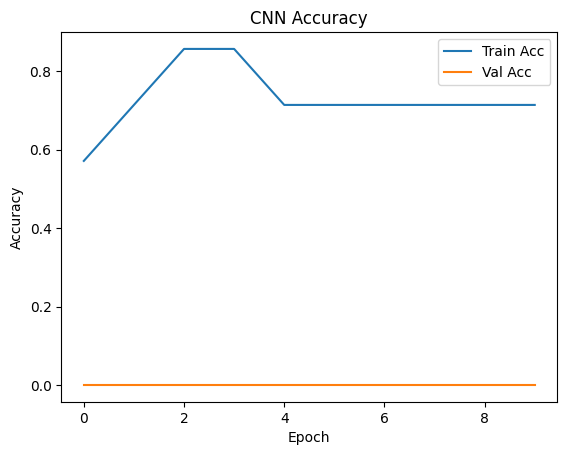

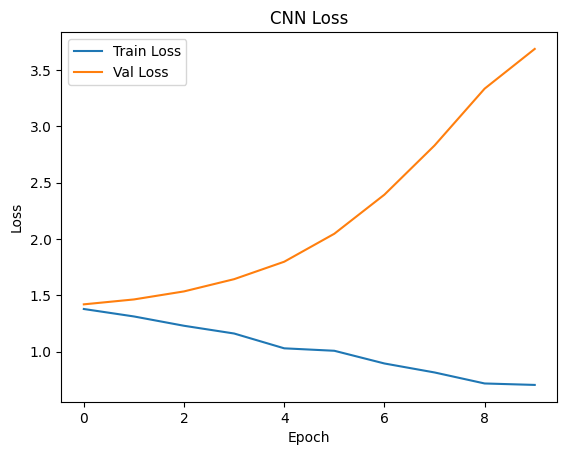

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss')
plt.show()


# Final Plot Suggestion: A Confusion Matrix

- shows what classes your model predicts well and where it struggles.

In [41]:
# Get Model Predictions
# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


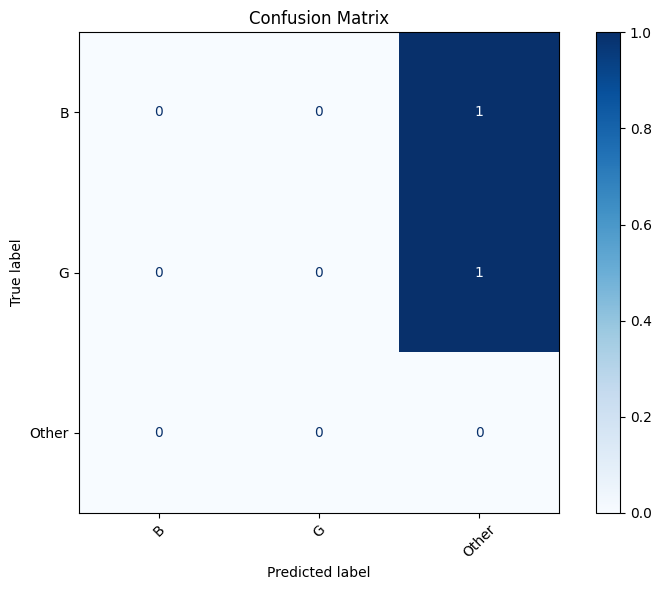

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Recompute confusion matrix and used labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get all labels used in either prediction or truth
all_used_classes = np.union1d(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred, labels=all_used_classes)
class_names_used = label_encoder.classes_[all_used_classes]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_used)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


This confusion matrix shows that the model did not correctly classify examples of classes B or G, but instead defaulting to Other. This suggests either class imbalance, insufficient training examples for B and G, or limited discriminatory features in the patch images themselves. Further data augmentation or a deeper model could improve performance.